In [1]:
import sys  
sys.path.append('../scripts/')
from mcl import *
from kf import * 

In [2]:
class EstimatedLandmark(Landmark):
    def __init__(self):
        super().__init__(0,0) 
        self.cov = None 
        
    def draw(self, ax, elems): 
        if self.cov is None: #ランドマークがまだ観測されていなければ描画しない
            return
        
        ###推定位置に青い星を描く###
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="blue")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))
        
        ###誤差楕円を描く###
        e = sigma_ellipse(self.pos, self.cov, 10)Z
        elems.append(ax.add_patch(e))

In [3]:
class MapParticle(Particle):  
    def __init__(self, init_pose, weight, landmark_num):
        super().__init__(init_pose, weight)
        self.map = Map() #ここでパーティクルに地図をもたせる
        
        for i in range(landmark_num): #ランドマークの数だけ繰り返す
            #パーティクルのマップに,ランドマークの位置を推定するためのガウス分布のパラメータを追加する
            self.map.append_landmark(EstimatedLandmark()) 
        
        
            #ランドマークの推定の初期化
    def init_landmark_estimation(self, landmark, z, distance_dev_rate, direction_dev):
        x, y, t = self.pose
        ell, phi = z　
        #観測したセンサ値はパーティクルからの相対的な位置であるから, パーティクルの姿勢をもとに世界座標系の位置に変換する
        mx, my = ell*math.cos(t + phi) + x, ell*math.sin(t + phi) + y 
    
        #ランドマーク位置とガウス分布の中心の差によって線形化を補正する行列Hを計算する 
        #ここでランドマーク位置のt-1を用いると, カルマンフィルタが収束しなくなる可能性があるためセンサ値を用いる
        H = np.array([[(mx - x)/math.sqrt(ell), (my - y)/math.sqrt(ell)], 
                                [                     (y - my)/ell,                   (mx - x)/ell]])
        
        #計測値の雑音の標準偏差から共分散行列Qを求める 
        Q = np.diag(np.array([(distance_dev_rate*ell)**2, direction_dev**2]))#標準偏差を2乗して分散にする
        
        landmark.cov = np.linalg.inv(H.T.dot( np.linalg.inv(Q) ).dot(H)) #ランドマークの位置の共分散行列を計算する
        landmark.pos = np.array([mx, my]).T #ランドマーク位置の分布の中心を, 観測したランドマーク位置から初期設定する
        
        #ランドマークの推定
    def observation_update_landmark(self, landmark, z, distance_dev_rate, direction_dev):  ###fastslam7
        x, y, _ = self.pose
        mx, my =  landmark.pos
        estm_z = IdealCamera.relative_polar_pos(self.pose, landmark.pos)
        estm_ell, _ = estm_z
        if estm_ell < 0.01: #ロボットとランドマークの距離が0.01未満の場合は計算しない
            return
        #Hは初期化とは異なり, t-1のランドマーク位置を使用する
        H = np.array([[(mx - x)/math.sqrt(estm_ell), (my - y)/math.sqrt(estm_ell)],  [(y - my)/estm_ell, (mx - x)/estm_ell]])
        #Qは初期化と同様に計算する
        Q = np.diag(np.array([(distance_dev_rate*estm_ell)**2, direction_dev**2]))
        #カルマンゲインを計算する #この値が大きいほどガウス分布の中心は大きく動く
        K = landmark.cov.dot(H.T).dot( np.linalg.inv(Q + H.dot(landmark.cov).dot(H.T)) )
        
        
        ###重みの更新###
        #観測値zの共分散行列を計算する 
        Q_z = H.dot(landmark.cov).dot(H.T) + Q
        #求めた共分散行列Q_zと中心estm_zのガウス分布から数値を取り出して, t-1の重みとかけて新たな重みとする
        self.weight *= multivariate_normal(mean=estm_z, cov=Q_z).pdf(z)
        
        ###ランドマークの推定の更新###
        landmark.pos = K.dot(z - estm_z) + landmark.pos #ランドマークの分布の中心を更新する
        landmark.cov = (np.eye(2) - K.dot(H)).dot(landmark.cov) #ランドマークの共分散行列を更新する
        
    def observation_update(self, observation, distance_dev_rate, direction_dev): 
        for d in observation: #観測したランドマークの数だけまわす
            z = d[0] 
            landmark = self.map.landmarks[d[1]]
            
            if landmark.cov is None: #初めて観測されたランドマークの場合は初期化を実行する
                self.init_landmark_estimation(landmark, z, distance_dev_rate, direction_dev)
            else:
                self.observation_update_landmark(landmark, z, distance_dev_rate, direction_dev)
                

In [4]:
class FastSlam(Mcl):
    def __init__(self, particle_num, init_pose, landmark_num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05): #雑音の標準偏差をここで設定
        super().__init__(None, init_pose, particle_num, motion_noise_stds, distance_dev_rate, direction_dev)
        
        #指定したパーティクル数だけパーティクルを作る #全てのパーティクルの重みの合計が1.0になるように設定する
        self.particles = [MapParticle(init_pose, 1.0/particle_num, landmark_num) for i in range(particle_num)]
        self.ml = self.particles[0]
        
    def observation_update(self, observation):  
        for p in self.particles: #パーティクルの数だけまわす
            p.observation_update(observation, self.distance_dev_rate, self.direction_dev) 
        self.set_ml()
        self.resampling()
        
    def draw(self, ax, elems):
        super().draw(ax, elems)
        self.ml.map.draw(ax, elems)
        

<IPython.core.display.Javascript object>


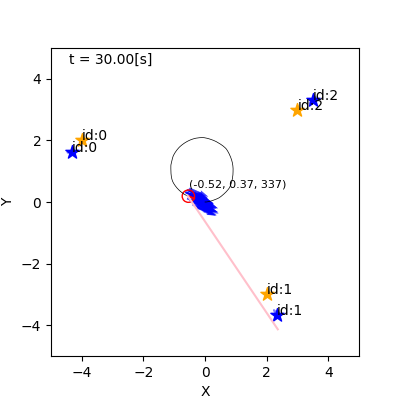

In [5]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval) 

    ###真の地図を作成###
    m = Map()
    landmark_positions = [(-4,2), (2,-3), (3,3)]
    for p in landmark_positions:
        m.append_landmark(Landmark(*p))
        
    world.append(m)       #ここより上は省略

    ### ロボットを作る ###
    init_pose = np.array([0,0,0]).T
    pf = FastSlam(100, init_pose, len(m.landmarks))
    a = MclAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(init_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()

In [6]:
a.pf.particles[10].map.landmarks[2].cov

In [7]:
math.sqrt(0.0025)

0.05